Very messy implementation of https://arxiv.org/pdf/2410.10103

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import diffrax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from src.generator import coupled_rossler
from src.koopman import *

# Generate dynamics 
In particular, trying to replicate Fig 1b.
Since the IC is not defned in the paper, tried to approximate i.e., eye-ball from the subfigure

### Specify parameters, ICs, timestepping

In [3]:
# Time span
t0, t1 = 0.0, 10.0
dt = 0.01
steps = int((t1 - t0) / dt)

# Parameters
phi1, phi2 = 1.0, 1.0  # Frequencies
a, b, d = 0.2, 0.2, 5.7  # Rössler parameters

# Initial condition (eye-ball from the paper)
initial_state = jnp.array([1.0, -2.0, 0.0, 0.0, 0.0, 0.0])

# Coupling coefficients 
# (causal direction: Omega 2 --> Omega 1; but NOT Omega 1 --> Omega 2)
c2 = 0

### Integrate forward

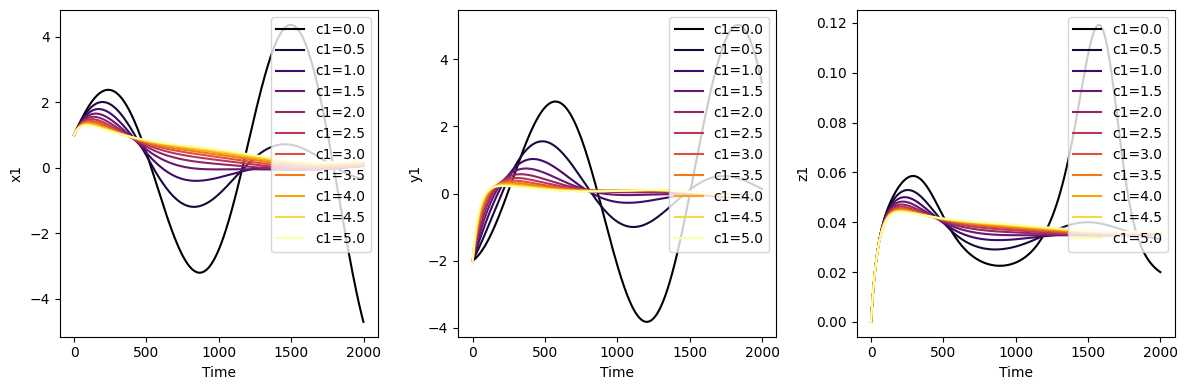

In [4]:
# Integration
solver = diffrax.Dopri5()  # Runge-Kutta solver

# Create figure
f, ax = plt.subplots(1, 3, figsize=(12, 4))

# Generate color map
c1_values = jnp.linspace(0, 5, 11)  # Coupling strength values
colors = cm.inferno(jnp.linspace(0, 1, len(c1_values)))  # Inferno colormap

for c1, color in zip(c1_values, colors):
    params = (phi1, phi2, a, b, d, c1, c2)

    # Solve the system
    solution = diffrax.diffeqsolve(
        diffrax.ODETerm(coupled_rossler),
        solver=solver,
        t0=t0,
        t1=t1,
        dt0=dt,
        y0=initial_state,
        args=params,
        saveat=diffrax.SaveAt(ts=jnp.linspace(t0, t1, 2000)),
        max_steps=100000
    )

    # Extract results (divided into omega_1, omega_2)
    omega_1, omega_2 = solution.ys.T[:3], solution.ys.T[3:]

    # Plot the results
    ax[0].plot(omega_1[0], label=f"c1={c1:.1f}", color=color)
    ax[1].plot(omega_1[1], label=f"c1={c1:.1f}", color=color)
    ax[2].plot(omega_1[2], label=f"c1={c1:.1f}", color=color)

# Add labels and legends
for i, var in enumerate(["x1", "y1", "z1"]):
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(var)
    ax[i].legend(loc="upper right")

plt.tight_layout()
plt.show()

# Causal Koopman

### Causal dependence with increasing shifts

We evaluate the temporal dependence. We notice, as expected, that the causal dependence is getting weaker as the shift is increased.
All the above codes are abstracted for readability in the subsequent analysis.

In [5]:
# Integration
t0, t1 = 0.0, 40.0
dt = 0.01
steps = int((t1 - t0) / dt)
phi1, phi2 = 1.0, 1.0  # Frequencies
a, b, d = 0.2, 0.2, 5.7  # Rössler parameters
c1, c2 = 0.5, 0 # Coupling term
params = (phi1, phi2, a, b, d, c1, c2)

# Solve the system
solver = diffrax.Dopri5()  # Runge-Kutta solver
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(coupled_rossler),
    solver=solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=initial_state,
    args=params,
    saveat=diffrax.SaveAt(ts=jnp.linspace(t0, t1, steps)),
    max_steps=100000
)

# Extract results (divided into omega_1, omega_2)
omega = solution.ys.T
omega_1, omega_2 = omega[:3], omega[3:]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:41<00:00,  1.05s/it]


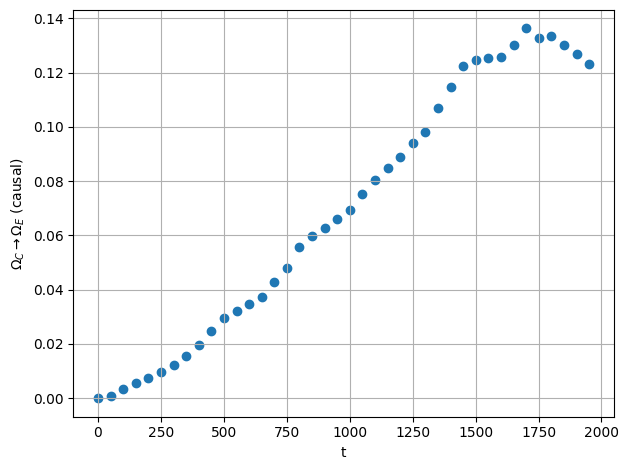

In [6]:
# Causal and non-causal direction (estimated by the causal loss)
time_shifts = jnp.arange(1, 2000, 50)
losses = {'causal': [], 'non_causal': []}

for t in tqdm(time_shifts):
    causal_loss, _, _ = compute_causal_loss(
        cause=omega_2, 
        effect=omega_1,
        t=t
    )
    
    losses['causal'].append(causal_loss)

# Plot
plt.scatter(time_shifts, losses['causal'])
plt.xlabel('t')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')
plt.grid()
plt.tight_layout()
plt.show;

### Causal-conditional forecasting
This is primarily to reproduce the algorithms introduced in Part IV section B, and Figure 4.

In [7]:
def conditional_forecasting(cause, effect, n_train, t=1):
    """
    Compute conditional forecasting by fitting K on a given training set, and iterating on a testing set
    given previous data point as the conditioning input.
    """
    
    effect_cause = jnp.concatenate([effect, cause], axis=0)
    N_cause, N_effect = cause.shape[0], effect.shape[0]
    D = cause.shape[1]

    ## Compute transforms
    omega_E, omega_Et, omega_EC, omega_ECt, psi_E, psi_Et, psi_EC, psi_ECt = compute_transforms(
        cause=cause[:, :n_train], 
        effect=effect[:, :n_train], 
        t=t
    )
    
    ## Learn K
    K_marginal, K_joint = compute_K(omega_E, psi_E, omega_EC, psi_EC, omega_Et)

    ## Compute marginal / joint on all data including test set
    omega_marginal, omega_joint = [effect[:, 0:1]], [effect[:, 0:1]]
    
    for d in range(D - t):
    
        # Marginal
        omega_marginal.append(
            K_marginal @ jnp.concatenate([omega_marginal[-1], random_fourier_features(effect[:, d:d+1])], axis=0)
        )
    
        # Joint
        omega_joint.append(
            K_joint @ jnp.concatenate([omega_joint[-1], random_fourier_features(effect_cause[:, d:d+1])], axis=0)
        )
    
    omega_marginal = jnp.array(omega_marginal).squeeze().T
    omega_joint = jnp.array(omega_joint).squeeze().T

    return omega_marginal, omega_joint

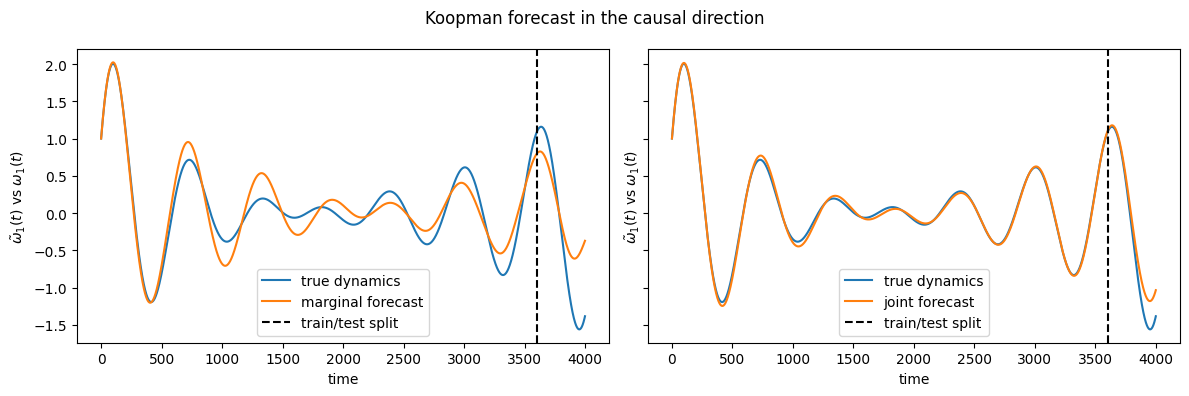

In [8]:
# Conditional inference (causal)
cause = omega_2
effect = omega_1
n_train = int(0.9 * steps)

omega_marginal, omega_joint = conditional_forecasting(
    cause = cause, 
    effect = effect, 
    n_train = n_train, 
    t=1
)

# Plot
param_id = 0

f, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
ax[0].plot(effect[param_id], label='true dynamics')
ax[0].plot(omega_marginal[param_id], label='marginal forecast')
ax[0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[0].set_xlabel('time')
ax[0].set_ylabel(r'$\tilde{\omega}_1(t)$ vs $\omega_1(t)$')
ax[0].legend()

ax[1].plot(effect[param_id], label='true dynamics')
ax[1].plot(omega_joint[param_id], label='joint forecast')
ax[1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[1].set_xlabel('time')
ax[1].set_ylabel(r'$\tilde{\omega}_1(t)$ vs $\omega_1(t)$')
ax[1].legend()

f.suptitle('Koopman forecast in the causal direction')
plt.tight_layout()
plt.show();


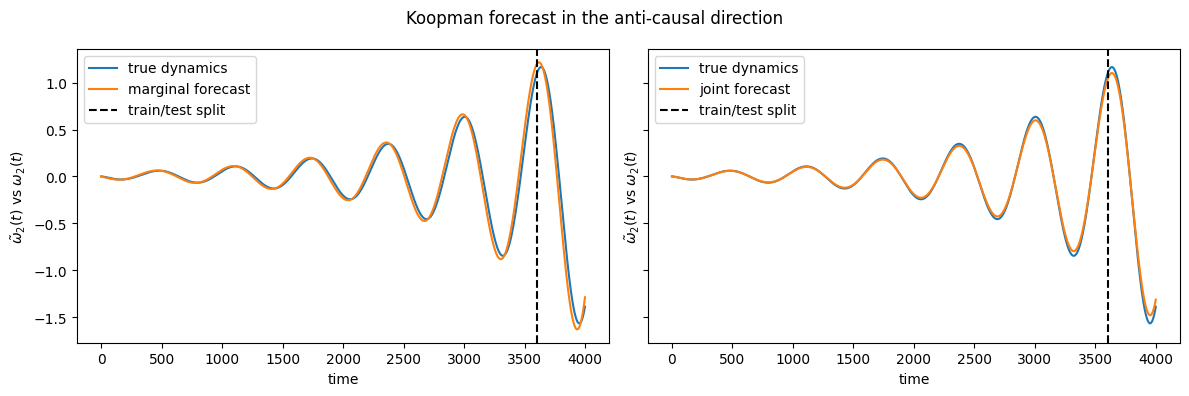

In [9]:
# Conditional inference (anti-causal)
cause = omega_1
effect = omega_2
n_train = int(0.9 * steps)

omega_marginal, omega_joint = conditional_forecasting(
    cause = cause, 
    effect = effect, 
    n_train = n_train, 
    t=1
)

# Plot
param_id = 0

f, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
ax[0].plot(effect[param_id], label='true dynamics')
ax[0].plot(omega_marginal[param_id], label='marginal forecast')
ax[0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[0].set_xlabel('time')
ax[0].set_ylabel(r'$\tilde{\omega}_2(t)$ vs $\omega_2(t)$')
ax[0].legend()

ax[1].plot(effect[param_id], label='true dynamics')
ax[1].plot(omega_joint[param_id], label='joint forecast')
ax[1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[1].set_xlabel('time')
ax[1].set_ylabel(r'$\tilde{\omega}_2(t)$ vs $\omega_2(t)$')
ax[1].legend()

f.suptitle('Koopman forecast in the anti-causal direction')
plt.tight_layout()
plt.show();
